In [70]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
with open("../data/interim/02_extracted_basic_numerical_comparison.pkl", "rb") as f:
    wiki_df = pickle.load(f)

Get only the numerical data for plotting

In [3]:
wiki_df.columns

Index(['parent_title', 'parent_url', 'child_title', 'child_url', 'comparison',
       'parent_extract', 'parent_links', 'parent_linkshere',
       'parent_categories', 'parent_redirects', 'child_extract', 'child_links',
       'child_linkshere', 'child_categories', 'child_redirects',
       'parent_direct_to_child', 'child_direct_to_parent',
       'parent_path_to_child', 'child_path_to_parent', 'shared_categories',
       'shared_links', 'shared_linkshere'],
      dtype='object')

In [4]:
wiki_numerical_df = wiki_df[['parent_direct_to_child', 'child_direct_to_parent',
       'parent_path_to_child', 'child_path_to_parent', 'shared_categories',
       'shared_links', 'shared_linkshere']].copy()

## Scaling and clustering

In [90]:
# scaler = RobustScaler()
# scaler = StandardScaler()
# scaler = Normalizer()
# scaler = MinMaxScaler()
scaler = MaxAbsScaler()


scaled = scaler.fit_transform(wiki_numerical_df)
scaled_df = pd.DataFrame(scaled, columns=wiki_numerical_df.columns)

In [91]:
kmeans = KMeans(n_clusters=4, n_jobs=-1)

kmeans.fit(scaled);
# scaled_df["clusters"] = kmeans.labels_

scaled_with_labels = scaled_df.copy()
scaled_with_labels['labels'] = kmeans.labels_

unscaled_with_labels = wiki_numerical_df.copy()
unscaled_with_labels['labels'] = kmeans.labels_

unscaled_with_labels.head()

,parent_direct_to_child,child_direct_to_parent,parent_path_to_child,child_path_to_parent,shared_categories,shared_links,shared_linkshere,labels
0,1,1,1,2,0,2,1,1
1,1,1,6,9,0,10,10,1
2,1,0,8,2,1,21,2,0
3,1,0,2,1,0,1,1,0
4,1,1,8,6,0,10,11,1


In [41]:
silhouette_score(scaled, kmeans.labels_)

0.949428651375003

In [92]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
X = scaled_with_labels.drop("labels", axis=1)
y = scaled_with_labels.labels

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

rf.fit(X_train, y_train);

print("score:\t", rf.score(X_test, y_test))
print("Feature Importances:\t", list(zip(X.columns, rf.feature_importances_)))

score:	 0.99908655507826
Feature Importances:	 [('parent_direct_to_child', 0.04260023536038852), ('child_direct_to_parent', 0.7572671092859526), ('parent_path_to_child', 0.015248624812422604), ('child_path_to_parent', 0.09396528697559385), ('shared_categories', 0.012279254713149378), ('shared_links', 0.038454121064648066), ('shared_linkshere', 0.04018536778784474)]


# PCA for graphing

In [93]:
pca = PCA(n_components=2)

transformed = pca.fit_transform(scaled_df)

In [98]:
np.cumsum(pca.explained_variance_)

array([0.24773187, 0.26508235])

In [99]:
transformed_scaled_df = pd.DataFrame(transformed, columns=["PC1", "PC2"])
transformed_scaled_df['clusters'] = kmeans.labels_

In [100]:
transformed_scaled_df.head()

,PC1,PC2,clusters
0,-0.446638,-0.013857,1
1,-0.446886,-0.013864,1
2,0.552083,-0.022322,0
3,0.552530,-0.022314,0
4,-0.446871,-0.013863,1


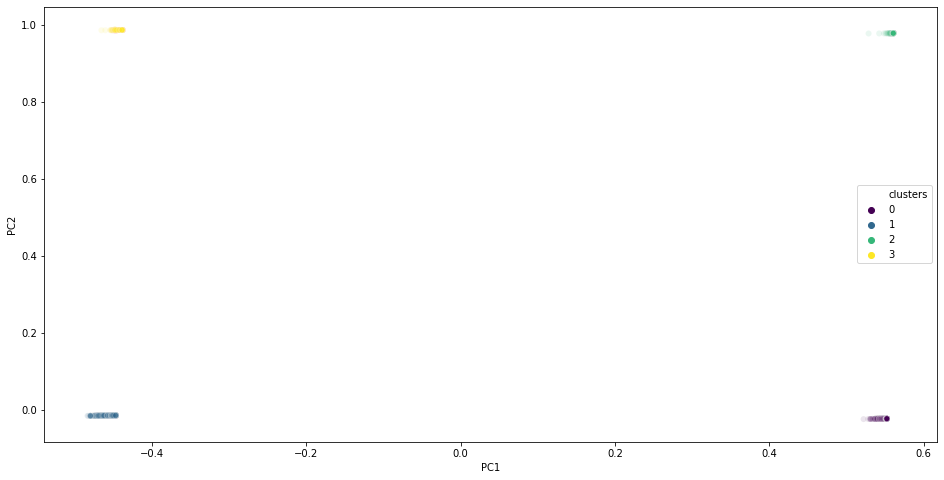

In [101]:
plt.figure(figsize=(16,8))
# sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=scaled_df.clusters)
# sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1])
sns.scatterplot(data=transformed_scaled_df, x="PC1", y="PC2", hue="clusters", palette="viridis", alpha=0.1)
plt.show()